<a href="https://colab.research.google.com/github/zekaouinoureddine/Advanced-transformer-based-models-on-opinion-mining/blob/master/notebooks/Movie_Reviews_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Movie Reviews BERT</strong></h1>

---

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 5.8 MB 14.8 MB/s 
     |████████████████████████████████| 7.6 MB 34.6 MB/s 
     |████████████████████████████████| 182 kB 77.9 MB/s 


### Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1qaw9jL-KpuSsjeP3K_2hc2mkrn9bdGJN -q
!unzip "IMDB Dataset.csv.zip"

In [ ]:
!gdown --id 1xJYm-tNMllxx82_CQ1K1R5q0JW9KUV1j -q
!unzip IMDb.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DATASETS/IMDb.zip

Archive:  /content/drive/MyDrive/DATASETS/IMDb.zip
  inflating: IMDB Dataset.csv        


In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:
df = pd.DataFrame({
    "review": ["hello worls", "mm kk world", "kmm state"],
    "sentiment": ["positive", "negative", "positive"],
})

df.to_csv("IMDB Dataset.csv")

In [ ]:
def plot_tokens_count(df: pd.DataFrame, colmun_name:str):
  token_lens = []
  for text in df[f"{colmun_name}"]:
    token_lens.append(len(text.split()))

  # sns.distplot(token_lens, color='red')
  plt.hist(token_lens, color='red', bins=50, alpha=0.5)
  plt.xlim([0, 800]);
  # plt.ylim([0, 0.020]);
  plt.xlabel("Tokens Count")
  plt.ylabel("Frequency")
  plt.show();

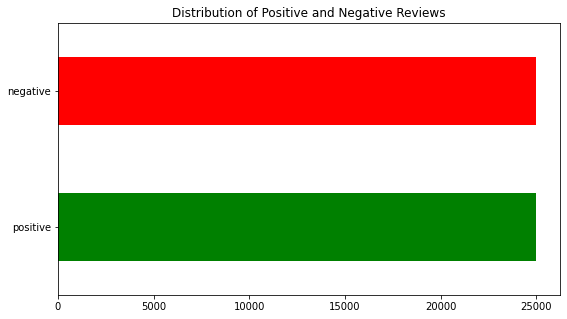

In [ ]:
# df = pd.read_csv("IMDB Dataset.csv")

df["sentiment"].value_counts().plot(kind='barh',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(9,5));

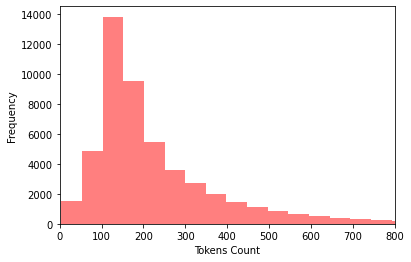

In [ ]:
plot_tokens_count(df, colmun_name="review")

### Config

In [ ]:
class Config:
  MAX_LEN = 64
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  BERT_PATH = "bert-base-uncased"
  MODEL_PATH = "BERTModel.bin"
  TRAINING_DATA = "IMDB Dataset.csv"

  TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case = True)
  MODEL = transformers.BertModel.from_pretrained(BERT_PATH, return_dict=False)

### Dataset

In [ ]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review
    
  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

class MovieReviewDatSet:
  def __init__(self, data_path):
    
    self.data = pd.read_csv(data_path).fillna('none')
    self.data.sentiment = self.data.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    self.data = self.data.reset_index(drop=True)
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = self.data.review.values
    self.label = self.data.sentiment.values

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())

    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = "max_length",
        truncation= True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
        }

### Model

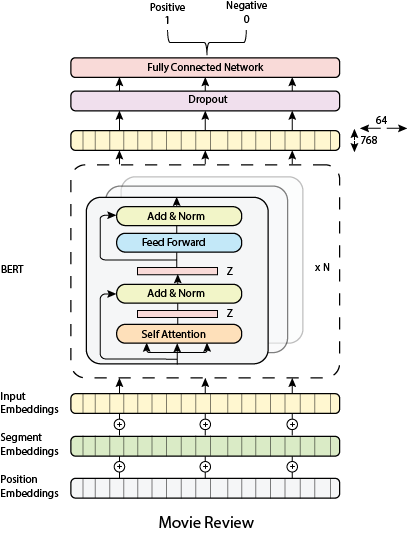

In [ ]:
class BERTModel(nn.Module):
  def __init__(self):
    super(BERTModel, self).__init__()
    self.bert = Config.MODEL
    self.bert_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output  = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    bo = self.bert_drop(pooled_output)
    output = self.out(bo)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    token_type_ids = d["token_type_ids"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      token_type_ids = d["token_type_ids"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### **Train**

In [ ]:
dataset = MovieReviewDatSet(Config.TRAINING_DATA)

train_data, valid_data = train_test_split(dataset, test_size = 0.1)
train_dataloader = DataLoader(train_data, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)
valid_dataloader = DataLoader(valid_data, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = BERTModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(train_data) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

### Error Analysis & Performance auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.8556
Recall Score    : 0.8682634730538922
Precision Score : 0.8472925594078691
F1 Score        : 0.8576498422712935

Classification report 

               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2495
         1.0       0.85      0.87      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



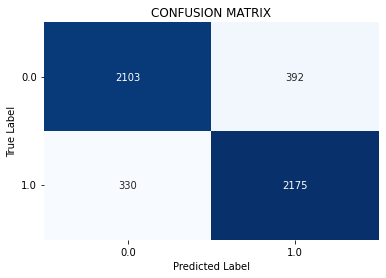

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

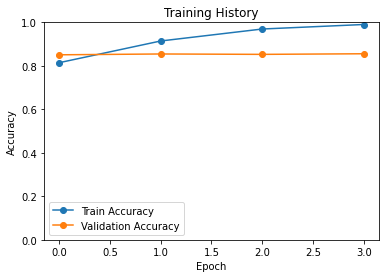

In [ ]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

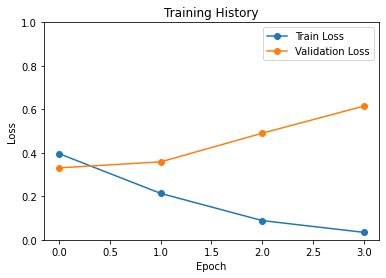

In [ ]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = BERTModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask, token_type_ids = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  token_type_ids = token_type_ids.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask, token_type_ids) 
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction
  
  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [ ]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.9976132', 'negative': '0.002386808395385742'}


### References:

* **Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. [BERT: Pre-training of deep bidirectional transformers for language understanding](https://arxiv.org/abs/1810.04805). In North American Association for Computational Linguistics (NAACL). arXiv preprint arXiv:1810.04805.**
